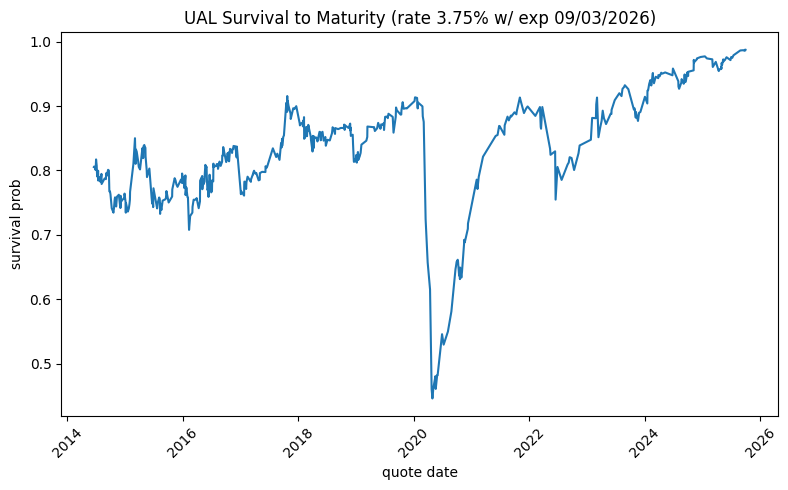

          date  last_value  spread_bps  spread_dec    hazard    tau_yrs  \
0   2014-06-19    106.3390    106.3390    0.010634  0.017723  12.216438   
1   2014-06-20    105.9590    105.9590    0.010596  0.017660  12.213699   
2   2014-06-23    106.1030    106.1030    0.010610  0.017684  12.205479   
3   2014-06-30    109.4790    109.4790    0.010948  0.018247  12.186301   
4   2014-07-03     99.5072     99.5072    0.009951  0.016585  12.178082   
5   2014-07-07    105.5130    105.5130    0.010551  0.017586  12.167123   
6   2014-07-08    110.0380    110.0380    0.011004  0.018340  12.164384   
7   2014-07-10    115.9600    115.9600    0.011596  0.019327  12.158904   
8   2014-07-16    110.5610    110.5610    0.011056  0.018427  12.142466   
9   2014-07-17    120.1020    120.1020    0.012010  0.020017  12.139726   
10  2014-07-18    116.3200    116.3200    0.011632  0.019387  12.136986   
11  2014-07-28    118.8150    118.8150    0.011881  0.019803  12.109589   

       s_tau  
0   0.805

In [56]:
#import libraries 

import pandas as pd, numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

#========================================

#loading csv 

file = r"C:\Users\LiamRodgers\Desktop\Python\Classes\FE800\FE800-Research\NewUAL\UALPricingnew.csv"
df = pd.read_csv(file)


#keeping date to last in spread 

df = df.rename(columns={"Date":"date","Last":"last_value"}).loc[:,["date","last_value"]]

#========================================

#parse dates + numeric 

def dates(x):
    
    for fmt in ("%m/%d/%Y","%m/%d/%y","%Y-%m-%d"):
        
        try: return datetime.strptime(str(x), fmt).date()
        except: pass
    return pd.NaT


def tnum(x):
    
    s = str(x).replace(",", "").strip()
    
    try: return float(s)
    except: return np.nan
    

df["date"] = df["date"].apply(dates)
df["last_value"] = df["last_value"].apply(tnum)
df = df.dropna(subset=["date", "last_value"]).sort_values("date").reset_index(drop=True)

#========================================

#reduced form - spread, hzrd, survival probs 


df["spread_bps"] = df["last_value"]          
df["spread_dec"] = df["spread_bps"] / 1e4


#assuming recovery rate 

r = 0.4                                      
df["hazard"] = df["spread_dec"] / (1 - r)


#taking exp maturity from bond des

expm = datetime(2026, 9, 3).date()

df["tau_yrs"] = (pd.to_datetime(expm) - pd.to_datetime(df["date"])).dt.days / 365.0
df = df[df["tau_yrs"] >= 0].copy()


#calculating survival under constant hzrd to maturity 

df["s_tau"] = np.exp(-df["hazard"] * df["tau_yrs"])

#save as csv 

#saved = "/Users/anthonygiller/Downloads/UAL_reduced_form_survival.csv"
#df.to_csv("UAL_survival_to_maturity.csv", index=False)

#========================================

#plot survival prob 

plt.figure(figsize=(8,5))

plt.plot(df["date"], df["s_tau"])
plt.title("UAL Survival to Maturity (rate 3.75% w/ exp 09/03/2026)")
plt.xlabel("quote date") 
plt.ylabel("survival prob")

plt.xticks(rotation=45) 
plt.tight_layout() 
plt.show()


print(df.head(12))


In [57]:
df.rename(columns ={'tau_yrs': 'Time_to_Maturity'}, inplace=True)
df = df[['date', 'Time_to_Maturity', 'last_value', 'spread_bps', 'spread_dec', 'hazard', 's_tau']]

In [58]:
#Fitting the hazard rate curve with exponential spline

import numpy as np
from scipy.optimize import curve_fit

def exp_spline(t, beta1, beta2, beta3, l1, l2, l3):
    return beta1 * np.exp(-l1 * t) + beta2 * np.exp(-l2 * t) + beta3 * np.exp(-l3 * t) #Equation for splining

# Initial guesses for β and λ, we can tune these if needed
p0 = [0.6, 0.3, 0.1, 0.2, 0.05, 0.01]

params, covariance = curve_fit(
    exp_spline, df['Time_to_Maturity'], df['s_tau'], p0=p0,
    bounds=(0, [1, 1, 1, 5, 1, 0.5]) # coefficients sum to 1, rates positive
)

beta1, beta2, beta3, l1, l2, l3 = params
print("Fitted parameters:", params)

df['Q_fit_spline'] = exp_spline(df['Time_to_Maturity'], *params)



Fitted parameters: [0.33616352 0.41510886 0.40127934 0.51575023 0.0025632  0.00259161]


In [59]:
#Fitting Nelson-Siegel model

def nelson_siegel(t, beta0, beta1, beta2, lamb):
    t = np.maximum(t, 1e-6)
    return beta0 + beta1 * (1 - np.exp(-lamb * t)) / (lamb * t) + beta2 * ((1 - np.exp(-lamb * t)) / (lamb * t) - np.exp(-lamb * t))

p0 = [0.8, -0.2, -0.1, 0.5]
params_ns, _ = curve_fit(nelson_siegel, df['Time_to_Maturity'], df['s_tau'], p0=p0)
df['NS_fit'] = nelson_siegel(df['Time_to_Maturity'], *params_ns)

In [60]:
from scipy.interpolate import UnivariateSpline


df_sorted = df.sort_values('Time_to_Maturity')
cubic_spline = UnivariateSpline(df_sorted['Time_to_Maturity'], df_sorted['s_tau'], k=3)
df_sorted['cubic_fit'] = cubic_spline(df_sorted['Time_to_Maturity'])



In [61]:
from scipy.interpolate import interp1d
knots = np.arange(3, 12, 3)

piecewise_fit = interp1d(df['Time_to_Maturity'], df['s_tau'], kind='linear', fill_value="extrapolate")
df['piecewise_fit'] = piecewise_fit(df['Time_to_Maturity'])


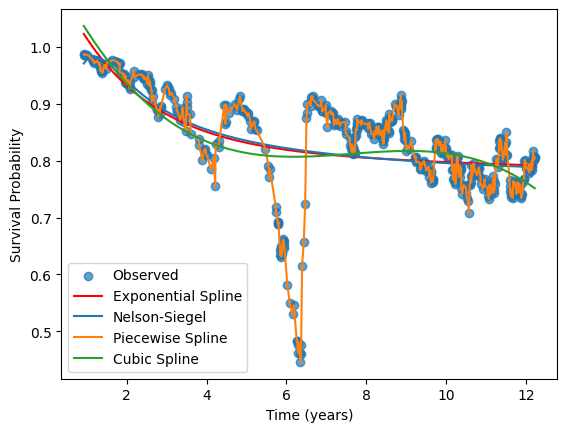

In [62]:
# Create fitted curve

plt.scatter(df['Time_to_Maturity'], df['s_tau'], label="Observed", alpha=0.7)
plt.plot(df['Time_to_Maturity'], exp_spline(df['Time_to_Maturity'], *params), label="Exponential Spline", color = 'red')
plt.plot(df['Time_to_Maturity'], df['NS_fit'], label="Nelson-Siegel")
#plt.plot(df['Time_to_Maturity'], df['cubic_fit'], label="Cubic Spline", linestyle="--")
plt.plot(df['Time_to_Maturity'], df['piecewise_fit'], label="Piecewise Spline")
plt.plot(df_sorted['Time_to_Maturity'], df_sorted['cubic_fit'], label="Cubic Spline")
plt.xlabel("Time (years)")
plt.ylabel("Survival Probability")
plt.legend()
plt.show()


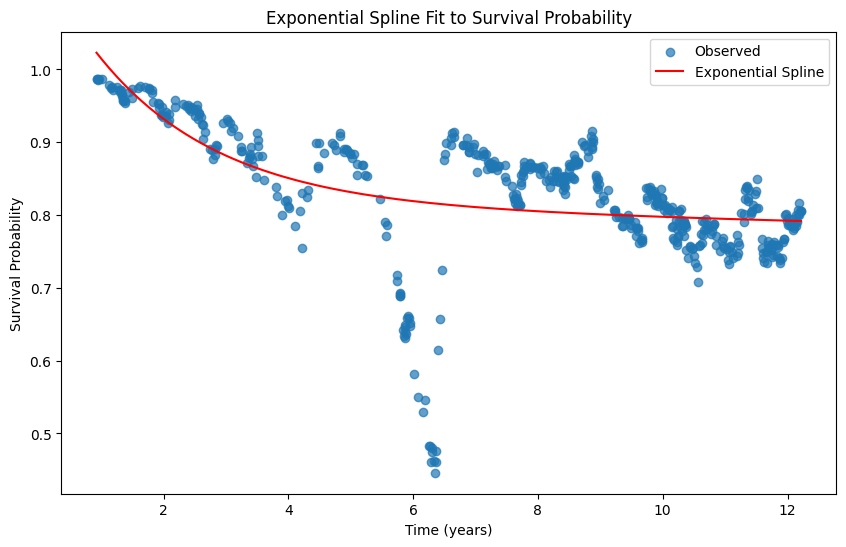

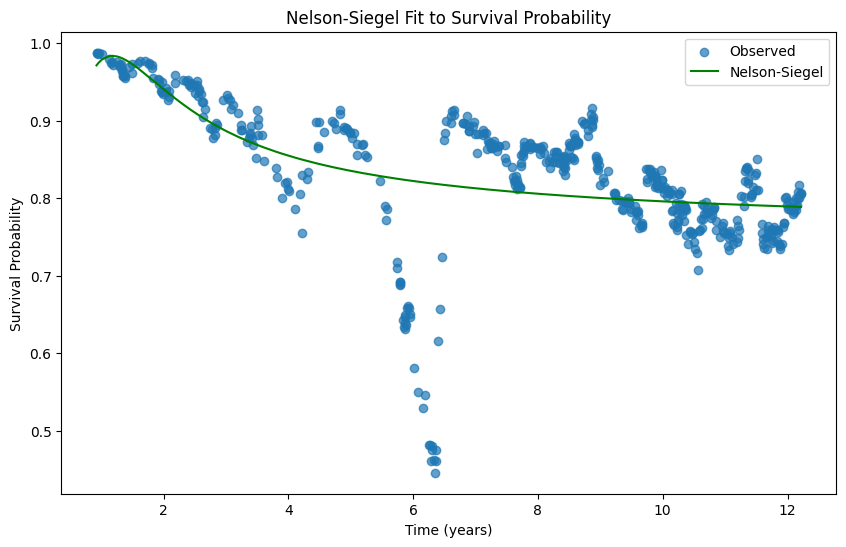

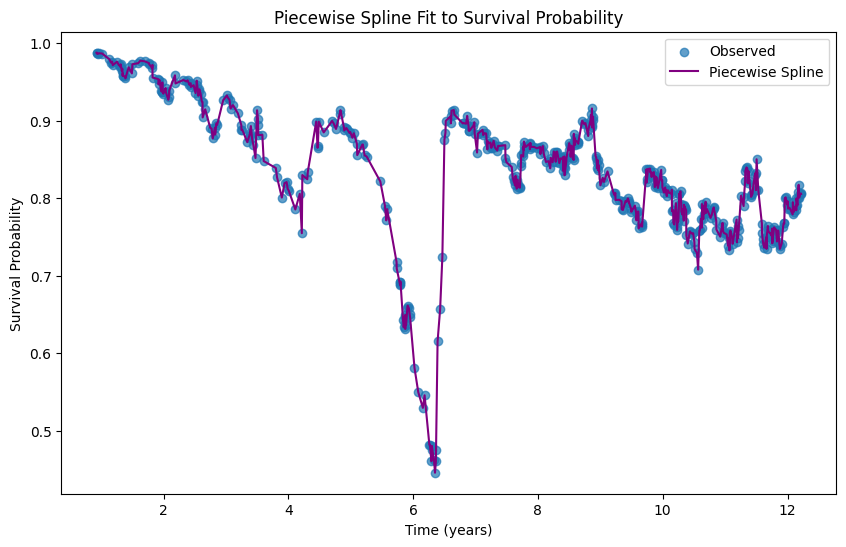

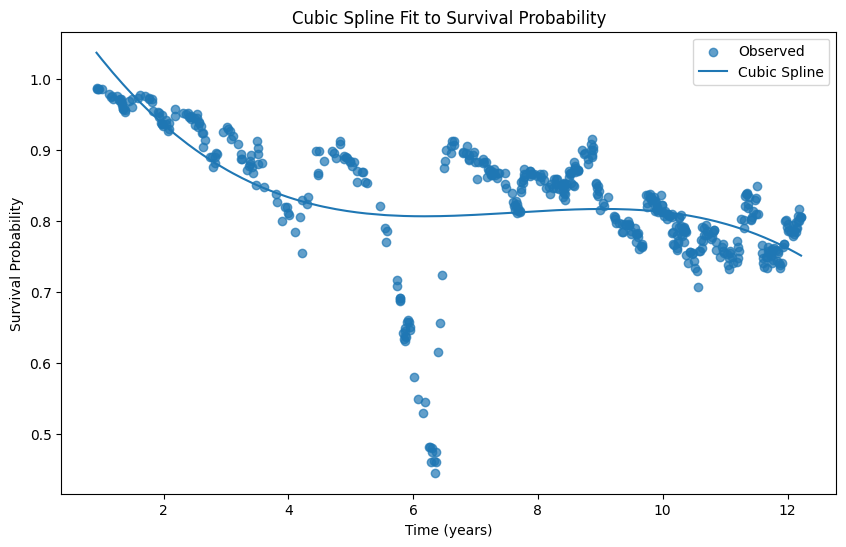

In [66]:
#Exp Spline plot
plt.figure(figsize=(10, 6))
plt.scatter(df['Time_to_Maturity'], df['s_tau'], label="Observed", alpha=0.7)
plt.plot(df['Time_to_Maturity'], exp_spline(df['Time_to_Maturity'], *params), label="Exponential Spline", color = 'red')
plt.xlabel("Time (years)")
plt.ylabel("Survival Probability")
plt.title("Exponential Spline Fit to Survival Probability")
plt.legend()
plt.show()

#Nelson-Siegel plot
plt.figure(figsize=(10, 6))
plt.scatter(df['Time_to_Maturity'], df['s_tau'], label="Observed", alpha=0.7)
plt.plot(df['Time_to_Maturity'], nelson_siegel(df['Time_to_Maturity'], *params_ns), label="Nelson-Siegel", color = 'green')
plt.xlabel("Time (years)")
plt.ylabel("Survival Probability")
plt.title("Nelson-Siegel Fit to Survival Probability")
plt.legend()
plt.show()

#Piecewise plot
plt.figure(figsize=(10, 6))
plt.scatter(df['Time_to_Maturity'], df['s_tau'], label="Observed", alpha=0.7)
plt.plot(df['Time_to_Maturity'], df['piecewise_fit'], label="Piecewise Spline", color = 'purple')
plt.xlabel("Time (years)")
plt.ylabel("Survival Probability")
plt.title("Piecewise Spline Fit to Survival Probability")
plt.legend()
plt.show()

#Cublic Spline plot
plt.figure(figsize=(10, 6))
plt.scatter(df['Time_to_Maturity'], df['s_tau'], label="Observed", alpha=0.7)
plt.plot(df_sorted['Time_to_Maturity'], df_sorted['cubic_fit'], label="Cubic Spline")
plt.xlabel("Time (years)")
plt.ylabel("Survival Probability")
plt.title("Cubic Spline Fit to Survival Probability")
plt.legend()
plt.show()

In [ ]:
df_survival = df.loc[:, ['date', 's_tau', 'Q_fit_spline']]
df_survival['date'] = pd.to_datetime(df_survival['date'])
df_survival = df_survival.resample('ME', on='date').mean()
df_survival.reset_index(inplace=True)

**Next step is to price with the survival based framework**

In [ ]:
#Bond information
from datetime import datetime

coupon_freq = 2 # semi-annual
coupon_rate = 0.0375/coupon_freq
issue_date = datetime(2014, 7, 28)
first_coupon_date = datetime(2015, 3, 3)
par = 1000
coupon_amount = par * coupon_rate
maturity =  datetime(2026, 9, 3)

##Havinng a problem adding the final payment here
dates = pd.date_range(start=first_coupon_date, end=maturity, freq='6MS').tolist()
if dates[-1] < maturity:
    dates.append(maturity)
    
    
    
schedule = []

for d in dates:
    cashflow = coupon_amount
    principal = 0
    if d == maturity:
        cashflow += par
        principal = par
    schedule.append({
        "date": d,
        "cashflow": cashflow,
        "coupon": coupon_amount,
        "principal": principal
    })

df_schedule = pd.DataFrame(schedule)
df_schedule#.head()

,date,cashflow,coupon,principal
0,2015-04-01,18.75,18.75,0
1,2015-10-01,18.75,18.75,0
2,2016-04-01,18.75,18.75,0
3,2016-10-01,18.75,18.75,0
4,2017-04-01,18.75,18.75,0
5,2017-10-01,18.75,18.75,0
6,2018-04-01,18.75,18.75,0
7,2018-10-01,18.75,18.75,0
8,2019-04-01,18.75,18.75,0
9,2019-10-01,18.75,18.75,0


In [ ]:
df_risk_free = pd.read_csv(r"C:\Users\LiamRodgers\Desktop\Python\Classes\FE800\FE800-Research\3M_treasury_yields.csv")
df_risk_free.rename(columns ={'observation_date': 'date', 'DGS3MO': 'risk_free_rate'}, inplace=True)
df_risk_free['date'] = pd.to_datetime(df_risk_free['date'])
df_risk_free

,date,risk_free_rate
0,2015-04-01,0.01
1,2015-05-01,0.01
2,2015-06-01,0.01
3,2015-07-01,0.08
4,2015-08-01,0.08
...,...,...
122,2025-06-01,4.41
123,2025-07-01,4.41
124,2025-08-01,4.23
125,2025-09-01,4.02


In [ ]:
def match_risk_free_rates(df_schedule, df_risk_free, df_survival=None):
    """
    Match risk-free rates and survival probabilities to bond cashflows based on year-month
    
    Parameters:
    df_schedule: DataFrame with bond cashflow schedule
    df_risk_free: DataFrame with risk-free rates
    df_survival: DataFrame with survival probabilities (Q_fit column)
    
    Returns:
    DataFrame with matched risk-free rates and survival probabilities
    """
    # Create a copy to avoid modifying original
    df_matched = df_schedule.copy()
    
    # Convert dates to datetime if they aren't already
    df_matched['date'] = pd.to_datetime(df_matched['date'])
    df_risk_free_copy = df_risk_free.copy()
    df_risk_free_copy['date'] = pd.to_datetime(df_risk_free_copy['date'])
    
    # Create year-month columns for matching
    df_matched['year_month'] = df_matched['date'].dt.to_period('M')
    df_risk_free_copy['year_month'] = df_risk_free_copy['date'].dt.to_period('M')
    
    # Merge risk-free rates on year-month
    df_matched = df_matched.merge(
        df_risk_free_copy[['year_month', 'risk_free_rate']], 
        on='year_month', 
        how='left'
    )
    
    # If survival data is provided, merge Q_fit as well
    if df_survival is not None:
        df_survival_copy = df_survival.copy()
        df_survival_copy['date'] = pd.to_datetime(df_survival_copy['date'])
        df_survival_copy['year_month'] = df_survival_copy['date'].dt.to_period('M')
        
        df_matched = df_matched.merge(
            df_survival_copy[['year_month', 'Q_fit_spline']], 
            on='year_month', 
            how='left'
        )
    
    # Drop the temporary year_month column
    df_matched = df_matched.drop('year_month', axis=1)
    
    return df_matched

# Apply the function with both risk-free rates and survival probabilities
df_schedule_with_rates = match_risk_free_rates(df_schedule, df_risk_free, df_survival)
df_schedule_with_rates.replace(np.nan, 0, inplace=True)
df_schedule_with_rates#.to_clipboard()

,date,cashflow,coupon,principal,risk_free_rate,Q_fit_spline
0,2015-04-01,18.75,18.75,0,0.01,0.793742
1,2015-10-01,18.75,18.75,0,0.08,0.795046
2,2016-04-01,18.75,18.75,0,0.22,0.796456
3,2016-10-01,18.75,18.75,0,0.34,0.797885
4,2017-04-01,18.75,18.75,0,0.80,0.799504
5,2017-10-01,18.75,18.75,0,1.15,0.801376
6,2018-04-01,18.75,18.75,0,1.87,0.803302
7,2018-10-01,18.75,18.75,0,2.34,0.805751
8,2019-04-01,18.75,18.75,0,2.43,0.808566
9,2019-10-01,18.75,18.75,0,1.54,0.811721


In [ ]:
pricing_date = datetime(2015, 9, 3)
df_schedule_with_rates['t'] = df_schedule_with_rates['date'].apply(lambda x: (x - pricing_date).days / 365.0)
df_schedule_with_rates['discount_factor'] = np.exp(-df_schedule_with_rates['risk_free_rate'] * df_schedule_with_rates['t'])
df_schedule_with_rates

,date,cashflow,coupon,principal,risk_free_rate,Q_fit_spline,t,discount_factor
0,2015-04-01,18.75,18.75,0,0.01,0.793742,-0.424658,1.004256e+00
1,2015-10-01,18.75,18.75,0,0.08,0.795046,0.076712,9.938818e-01
2,2016-04-01,18.75,18.75,0,0.22,0.796456,0.578082,8.805768e-01
3,2016-10-01,18.75,18.75,0,0.34,0.797885,1.079452,6.928002e-01
4,2017-04-01,18.75,18.75,0,0.80,0.799504,1.578082,2.829555e-01
5,2017-10-01,18.75,18.75,0,1.15,0.801376,2.079452,9.150425e-02
6,2018-04-01,18.75,18.75,0,1.87,0.803302,2.578082,8.058614e-03
7,2018-10-01,18.75,18.75,0,2.34,0.805751,3.079452,7.421807e-04
8,2019-04-01,18.75,18.75,0,2.43,0.808566,3.578082,1.674644e-04
9,2019-10-01,18.75,18.75,0,1.54,0.811721,4.079452,1.868992e-03


In [ ]:
# Fix the pricing loop
df_schedule_with_rates['PV'] = 0.0

# Add Q_previous column (Q(0,t_{i-1})) 
df_schedule_with_rates['Q_previous'] = df_schedule_with_rates['Q_fit_spline'].shift(1).fillna(1.0)

for i in range(len(df_schedule_with_rates)):
    z = df_schedule_with_rates['discount_factor'].iloc[i]
    cash = df_schedule_with_rates['cashflow'].iloc[i]
    Q_current = df_schedule_with_rates['Q_fit_spline'].iloc[i]
    Q_previous = df_schedule_with_rates['Q_previous'].iloc[i]
    
    # PV of cashflow if no default
    pv_cash = z * cash * Q_current
    
    # PV of recovery if default occurs in this period
    # Recovery = Z * R * F * (Q_{i-1} - Q_i)
    pv_recovery = z * r * par * (Q_previous - Q_current)
    
    df_schedule_with_rates['PV'].iloc[i] = pv_cash + pv_recovery

df_schedule_with_rates

C:\Users\LiamRodgers\AppData\Local\Temp\ipykernel_25940\818948198.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_schedule_with_rates['PV'].iloc[i] = pv_cash + pv_recovery
C:\Users\LiamRodgers\AppData\Local\Temp\ipykernel_25940\81894

,date,cashflow,coupon,principal,risk_free_rate,Q_fit_spline,t,discount_factor,PV,Q_previous
0,2015-04-01,18.75,18.75,0,0.01,0.793742,-0.424658,1.004256e+00,9.780047e+01,1.000000
1,2015-10-01,18.75,18.75,0,0.08,0.795046,0.076712,9.938818e-01,1.429747e+01,0.793742
2,2016-04-01,18.75,18.75,0,0.22,0.796456,0.578082,8.805768e-01,1.265347e+01,0.795046
3,2016-10-01,18.75,18.75,0,0.34,0.797885,1.079452,6.928002e-01,9.968319e+00,0.796456
4,2017-04-01,18.75,18.75,0,0.80,0.799504,1.578082,2.829555e-01,4.058485e+00,0.797885
5,2017-10-01,18.75,18.75,0,1.15,0.801376,2.079452,9.150425e-02,1.306406e+00,0.799504
6,2018-04-01,18.75,18.75,0,1.87,0.803302,2.578082,8.058614e-03,1.151710e-01,0.801376
7,2018-10-01,18.75,18.75,0,2.34,0.805751,3.079452,7.421807e-04,1.048567e-02,0.803302
8,2019-04-01,18.75,18.75,0,2.43,0.808566,3.578082,1.674644e-04,2.350316e-03,0.805751
9,2019-10-01,18.75,18.75,0,1.54,0.811721,4.079452,1.868992e-03,2.608694e-02,0.808566


In [ ]:
bond_pv = df_schedule_with_rates['PV'].sum()
print(f'Bond PV: {bond_pv:.2f}')

Bond PV: 627.06
